# Underwater Object Detection with Faster R-CNN

This notebook is a step-by-step tutorial on how to train a Faster R-CNN model for object detection for underwater images. The dataset used in this notebook is the [Underwater Image Dataset](https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots). 

## Introduction 
Object detection is a computer vision task that involves both localizing objects in images and classifying them. Faster R-CNN is a popular deep learning model for object detection that is an evolution of the R-CNN and Fast R-CNN models. Faster R-CNN is composed of two modules: a region proposal network (RPN) that generates region proposals and a network that uses these proposals to detect objects. You can learn more about this network [here](https://arxiv.org/abs/1506.01497). The architecture used in this notebook is based on [this paper](https://www.researchgate.net/publication/368708716_Underwater_Object_Detection_Method_Based_on_Improved_Faster_RCNN).

In this notebook we will use some techniques to improve the performance of the model, such as data augmentation, transfer learning, and hyperparameter tuning, OHEM, GIOU loss, and Soft-NMS.

- **Data Augmentation**: Data augmentation is a technique used to artificially increase the size of the training dataset by applying transformations to the images. This technique can help the model generalize better to new data and improve its performance.
- **Transfer Learning**: Transfer learning is a technique that allows you to use a pre-trained model as a starting point for training a new model on a different task. This can help you achieve better performance with less data and computational resources.
- **Hyperparameter Tuning**: Hyperparameter tuning is the process of finding the best set of hyperparameters for a machine learning model. This can help you improve the performance of the model and reduce the risk of overfitting.
- **OHEM**: Online Hard Example Mining (OHEM) is a technique used to focus the training process on the most challenging examples in the dataset. This can help the model learn from its mistakes and improve its performance.
- **GIOU Loss**: Generalized Intersection over Union (GIOU) is a loss function used to measure the similarity between two bounding boxes. This loss function can help the model learn to predict more accurate bounding boxes.
- **Soft-NMS**: Soft Non-Maximum Suppression (Soft-NMS) is a technique used to suppress overlapping bounding boxes by reducing the confidence scores of nearby boxes. This can help the model produce more accurate detections.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import os
from PIL import Image
import xml.etree.ElementTree as ET

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision import transforms
import torchvision.ops as ops

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import os
import json
from PIL import Image
import xml.etree.ElementTree as ET
import pprint
pp = pprint.PrettyPrinter(indent=4)

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision import transforms
import torchvision.ops as ops

import random
import cv2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### EDA (Exploratory Data Analysis)

we will start by loading the dataset and exploring its contents. The dataset contains images of underwater scenes with annotations for the objects present in the images. We will load the images and annotations, visualize some examples, and analyze the distribution of object classes in the dataset.

In [4]:
TRAIN_PATH = "../data/aquarium_pretrain/train"
VAL_PATH = "../data/aquarium_pretrain/valid"
TEST_PATH = "../data/aquarium_pretrain/test"

TRAIN_LABELS = TRAIN_PATH + "/labels"
VAL_LABELS = VAL_PATH + "/labels"
TEST_LABELS = TEST_PATH + "/labels"

TRAIN_IMAGES = TRAIN_PATH + "/images"
VAL_IMAGES = VAL_PATH + "/images"
TEST_IMAGES = TEST_PATH + "/images"

data = "../data/aquarium_pretrain/data.yaml"

In [5]:
classes = ["fish", "jellyfish", "penguin", "puffin", "shark", "starfish", "stingray"]
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print("Index to Label Mapping:", Idx2Label)
print("Label to Index Mapping:", Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


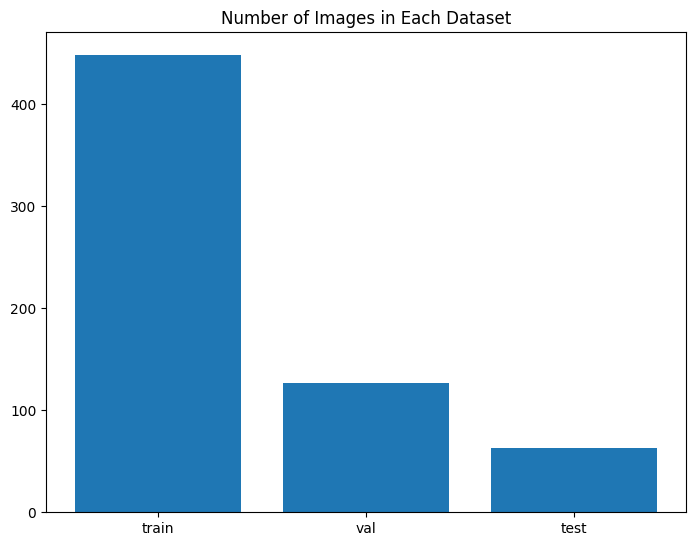

In [6]:
def plot_num_images(data, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(data.keys(), data.values())
    plt.title(title)
    plt.show()
    
def get_num_images(path):
    return len(os.listdir(path))

plot_num_images({ "train": get_num_images(TRAIN_IMAGES), "val": get_num_images(VAL_IMAGES), "test": get_num_images(TEST_IMAGES) }, "Number of Images in Each Dataset")

In [7]:
def count_objects_per_images(image_dir, label_dir, object_count, total_object_count):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        total_object_count.append(len(lines))
        for line in lines:
            object_count[Idx2Label[int(line.split()[0])]] = object_count.get(Idx2Label[int(line.split()[0])], 0) + 1
        f.close()
        
train_object_count = {}
val_object_count = {}
test_object_count = {}

total_object_per_train_count = []
total_object_per_val_count = []
total_object_per_test_count = []

count_objects_per_images(TRAIN_IMAGES, TRAIN_LABELS, train_object_count, total_object_per_train_count)
count_objects_per_images(VAL_IMAGES, VAL_LABELS, val_object_count, total_object_per_val_count)
count_objects_per_images(TEST_IMAGES, TEST_LABELS, test_object_count, total_object_per_test_count)

  0%|          | 0/448 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:00<00:00, 8373.19it/s]


In [8]:
pp.pprint(train_object_count)
print()
pp.pprint(val_object_count)
print()
pp.pprint(test_object_count)

{   'fish': 1961,
    'jellyfish': 385,
    'penguin': 330,
    'puffin': 175,
    'shark': 259,
    'starfish': 78,
    'stingray': 136}

{   'fish': 459,
    'jellyfish': 155,
    'penguin': 104,
    'puffin': 74,
    'shark': 57,
    'starfish': 27,
    'stingray': 33}

{   'fish': 249,
    'jellyfish': 154,
    'penguin': 82,
    'puffin': 35,
    'shark': 38,
    'starfish': 11,
    'stingray': 15}


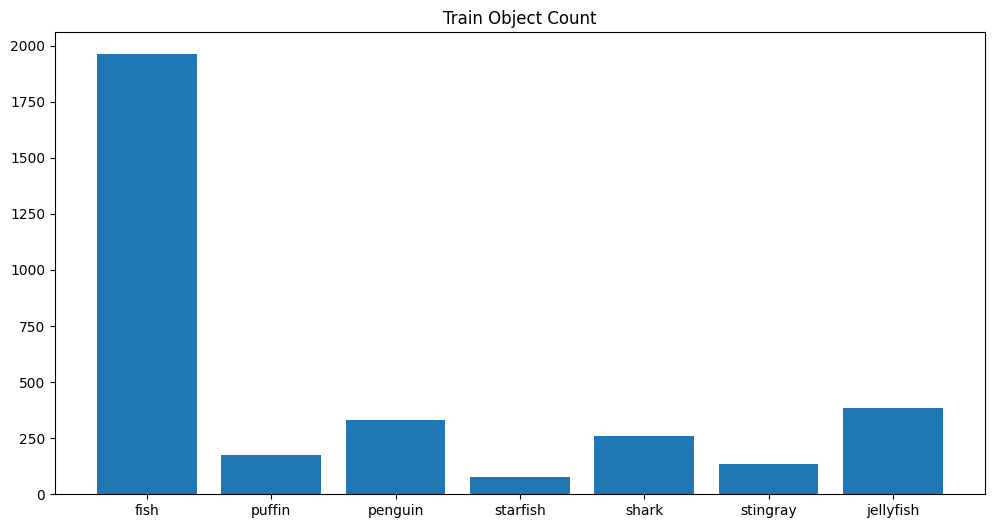

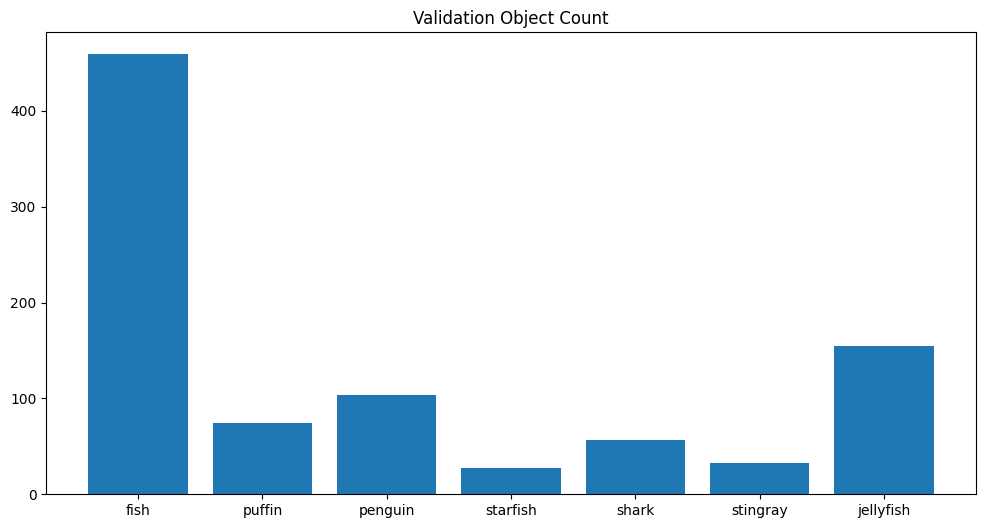

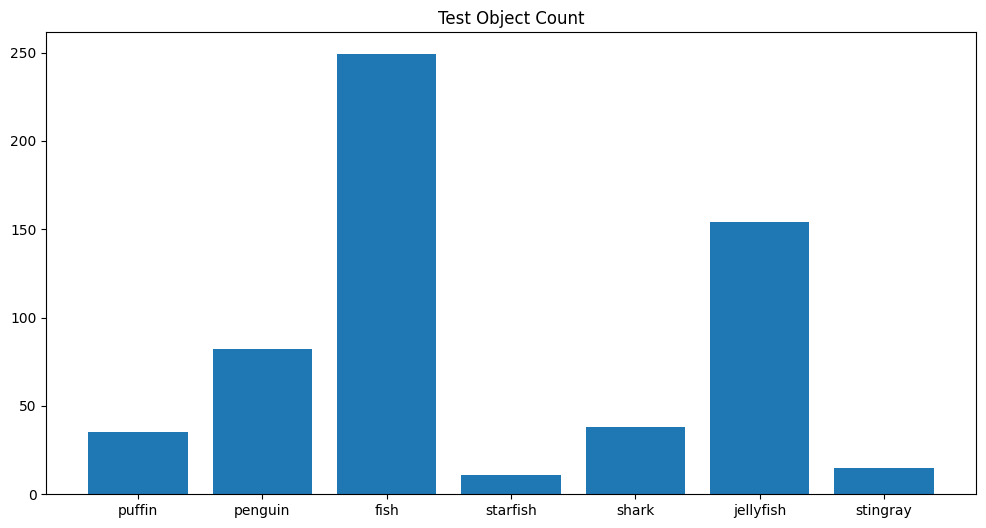

In [9]:
def plot_object_count(object_count, title):
    plt.figure(figsize=(12, 6))
    plt.bar(object_count.keys(), object_count.values())
    plt.title(title)
    plt.show()
    
plot_object_count(train_object_count, "Train Object Count")
plot_object_count(val_object_count, "Validation Object Count")
plot_object_count(test_object_count, "Test Object Count")

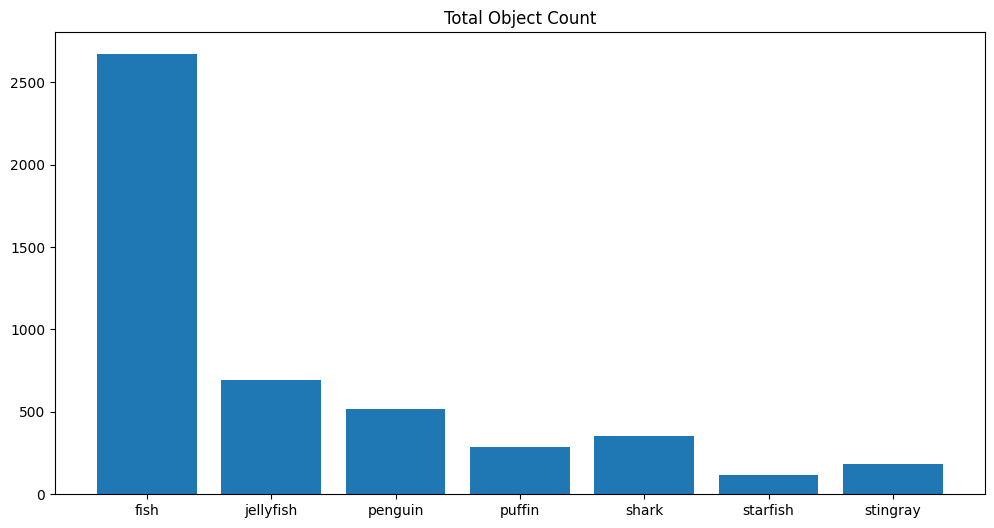

In [10]:
total_object_count = {label: train_object_count.get(label, 0) + val_object_count.get(label, 0) + test_object_count.get(label, 0) for label in classes}
plot_object_count(total_object_count, "Total Object Count")

Number of classes in the datasets are shown, as can be seen fishes are the most common class in the dataset, followed by jellyfish and penguins. This imbalance in the dataset can affect the performance of the model, so we will use techniques like data augmentation and OHEM to address this issue.

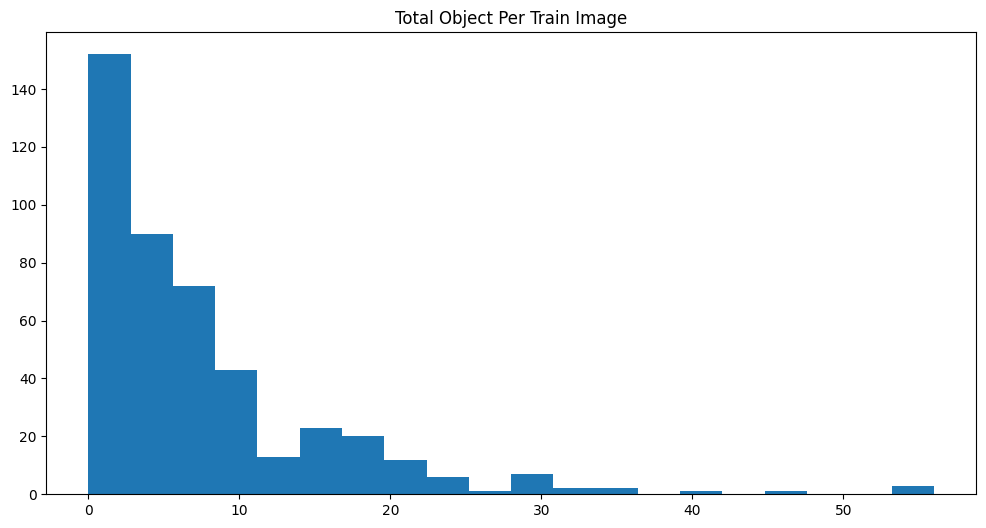

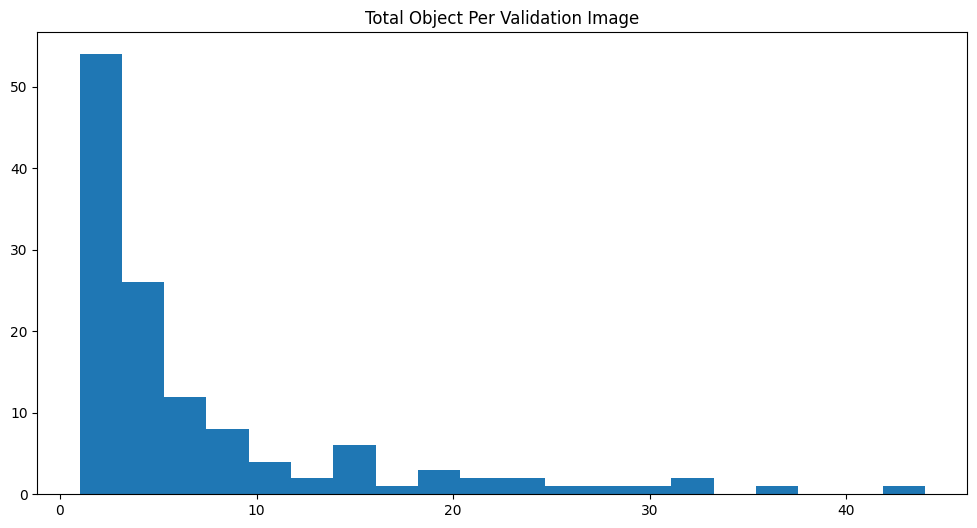

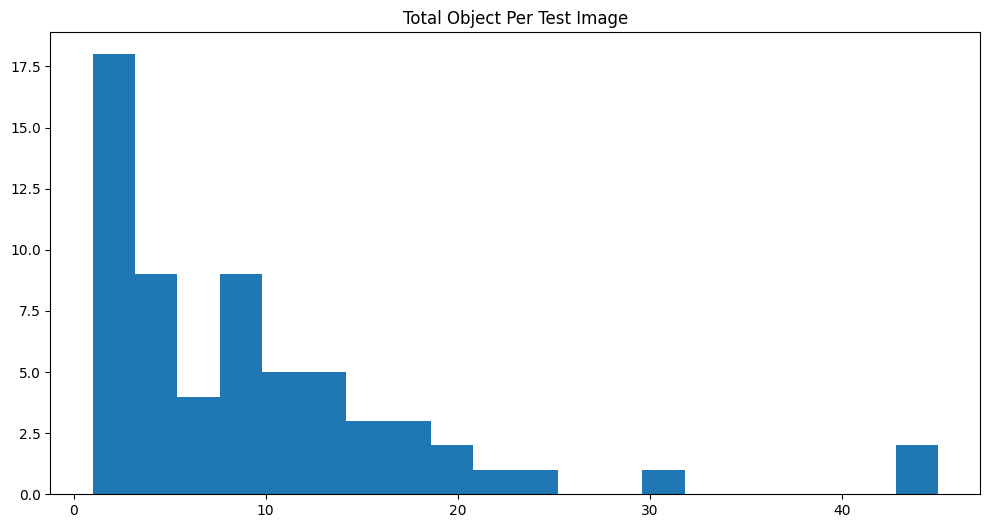

In [11]:
def plot_total_object_per_image(total_object_per_image, title):
    plt.figure(figsize=(12, 6))
    plt.hist(total_object_per_image, bins=20)
    plt.title(title)
    plt.show()
    
plot_total_object_per_image(total_object_per_train_count, "Total Object Per Train Image")
plot_total_object_per_image(total_object_per_val_count, "Total Object Per Validation Image")
plot_total_object_per_image(total_object_per_test_count, "Total Object Per Test Image")

The number of objects per image in all the datasets is shown, as can be seen most of the images contain 1-2 objects. All datasets have a similar distribution of objects per image, so we can use the same techniques for all datasets.

In [12]:
def get_bbox_sizes(image_dir, label_dir, sizes):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines:
            sizes.append(float(line.split()[3]) * float(line.split()[4]))
        f.close()
        
train_sizes = []
val_sizes = []
test_sizes = []

get_bbox_sizes(TRAIN_IMAGES, TRAIN_LABELS, train_sizes)
get_bbox_sizes(VAL_IMAGES, VAL_LABELS, val_sizes)
get_bbox_sizes(TEST_IMAGES, TEST_LABELS, test_sizes)

100%|██████████| 63/63 [00:00<00:00, 3563.89it/s]


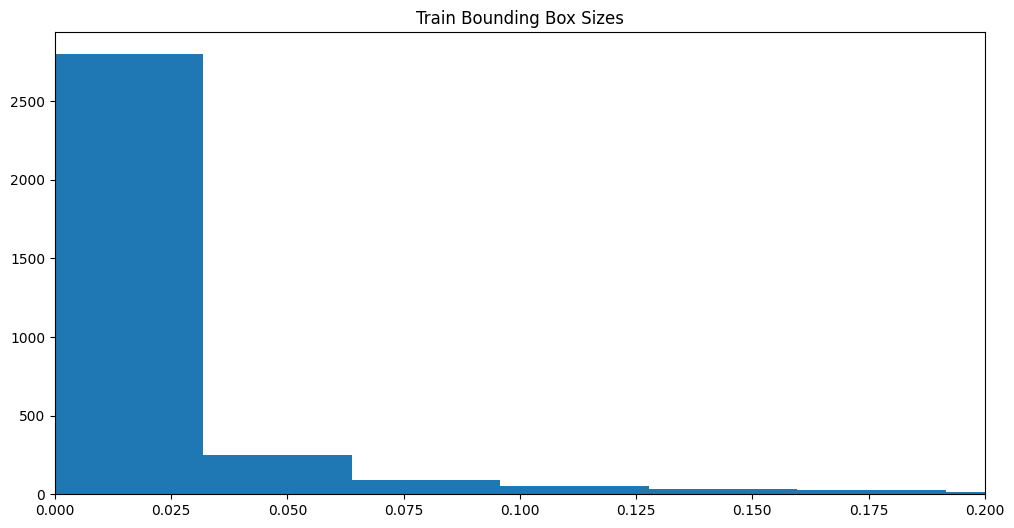

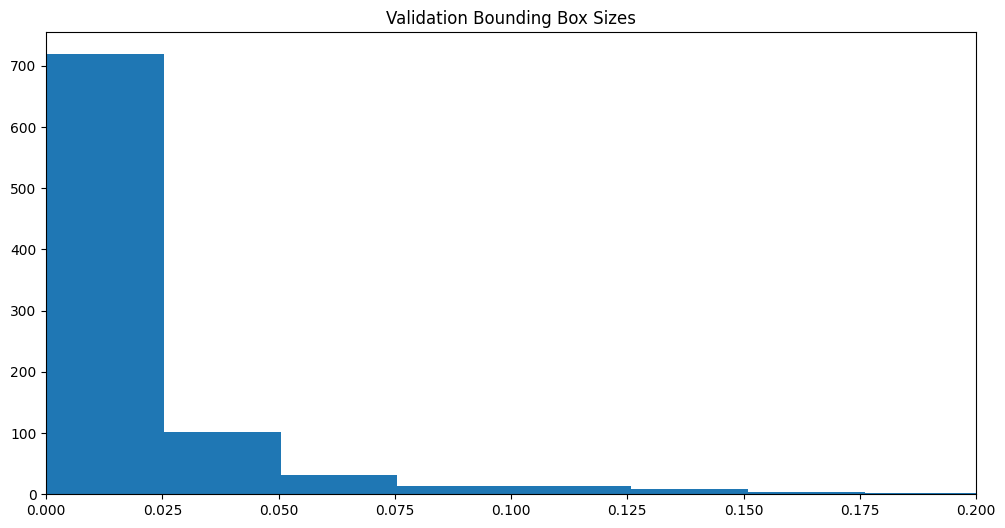

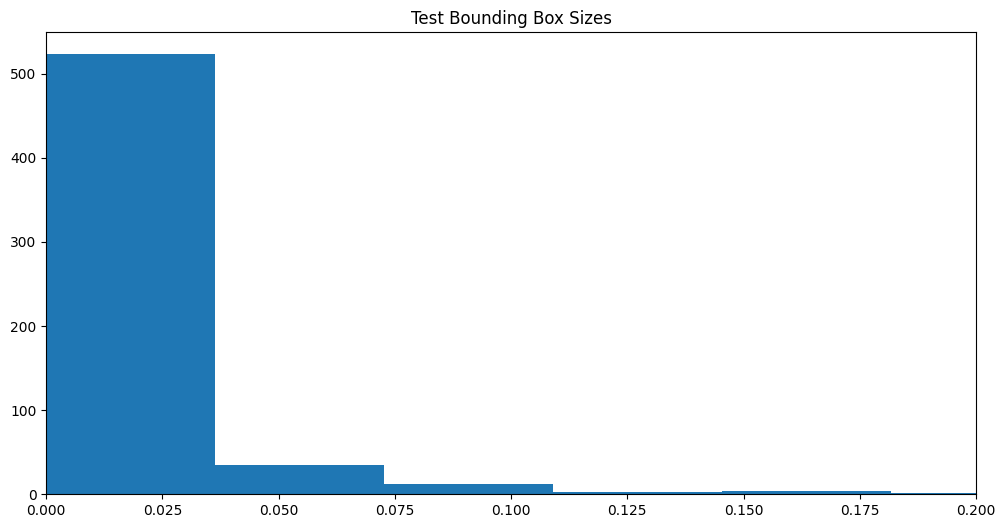

In [15]:
def plot_bbox_sizes(sizes, title):
    plt.figure(figsize=(12, 6))
    plt.hist(sizes, bins=20)
    plt.title(title)
    plt.xlim(0, .2)
    plt.show()
    
plot_bbox_sizes(train_sizes, "Train Bounding Box Sizes")
plot_bbox_sizes(val_sizes, "Validation Bounding Box Sizes")
plot_bbox_sizes(test_sizes, "Test Bounding Box Sizes")

The distribution of bounding box sizes in the datasets is shown. It can help us understand the scale of the objects in the images and choose an appropriate anchor size for the model. It can also be really helpful for our anchor generation.

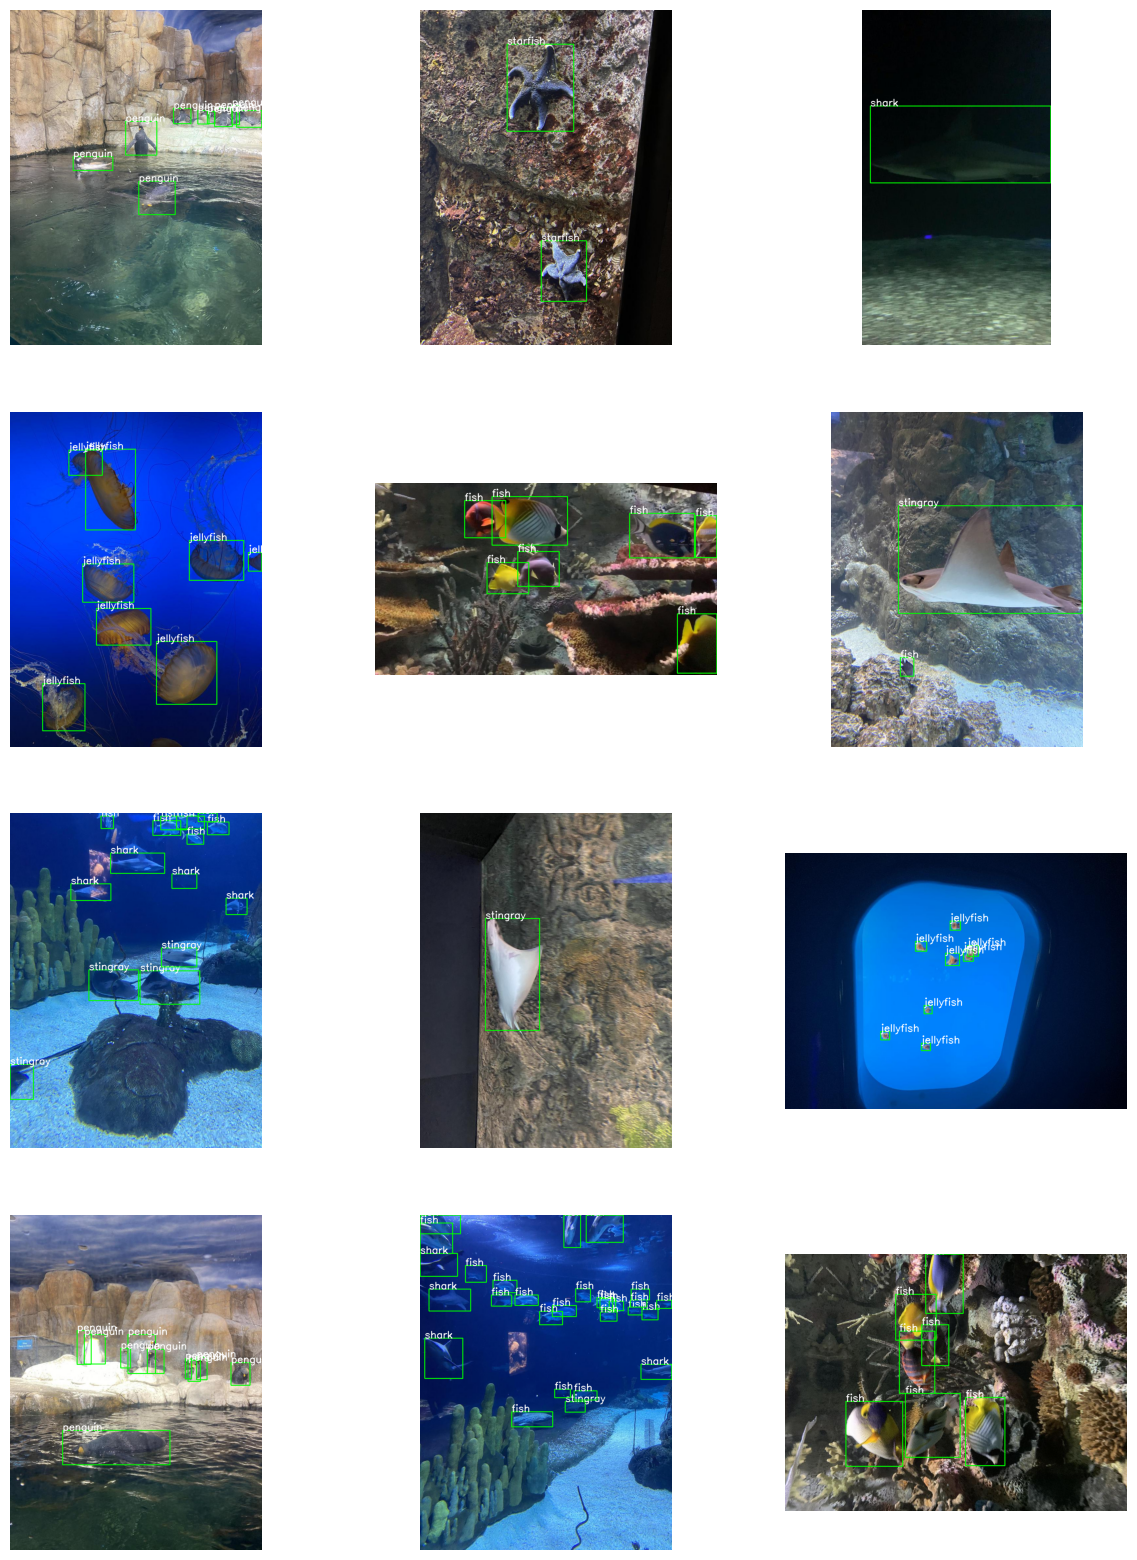

In [14]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_image_files = random.sample(image_files, 12)

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")

        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width / 2) * w)
            y_min = int((y_center - height / 2) * h)
            x_max = int((x_center + width / 2) * w)
            y_max = int((y_center + height / 2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(
                image,
                Idx2Label[int(class_id)],
                (x_min, y_min),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 255, 255),
                thickness=2,
            )

        axs[row, col].imshow(image)
        axs[row, col].axis("off")

    plt.show()


visualize_image_with_annotation_bboxes(TRAIN_IMAGES, TRAIN_LABELS)